## **Logistic Regression**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
df = pd.read_csv("au-bank.csv")  # Replace with your file path

# Preprocessing
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['direction'] = (df['close'] > df['prev_close']).astype(int)

In [3]:
# Features and target
features = ['open', '52w_high', '52w_low', 'volume', 'no_of_trades', 'day_of_week', 'month']
X = df[features]
y = df['direction']


In [4]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:

# Split into 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


In [6]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
# Best threshold finder
def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_probs >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred_thresh)
        scores.append((thresh, f1))
    best_thresh, best_f1 = max(scores, key=lambda x: x[1])
    
    # Plot Threshold vs F1
    thresholds_plot, f1_scores = zip(*scores)
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds_plot, f1_scores, color='blue', lw=2)
    plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold: {best_thresh:.2f}')
    plt.title("F1 Score vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Best Threshold: {best_thresh:.2f} with F1-score: {best_f1:.4f}")
    return best_thresh


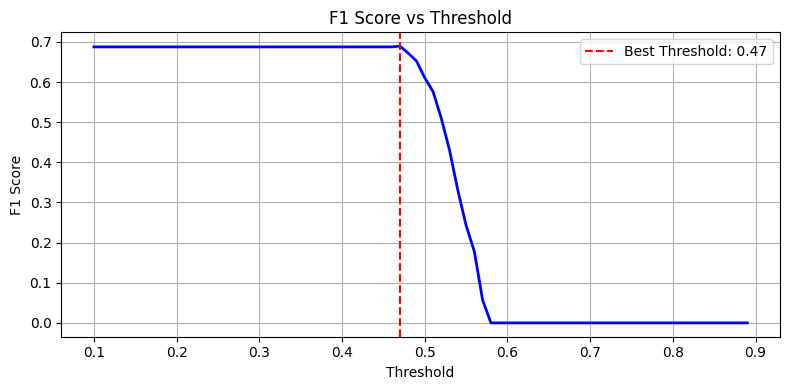


✅ Best Threshold: 0.47 with F1-score: 0.6893


In [9]:
# Find best threshold
t_best = find_best_threshold(y_val, y_val_probs)
y_val_pred = (y_val_probs >= t_best).astype(int)

In [10]:

# Validation evaluation
print("\nValidation Set Evaluation")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Test evaluation
y_test_probs = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_probs >= t_best).astype(int)

print("\n📊 Test Set Evaluation")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Validation Set Evaluation
Accuracy: 0.5277777777777778
Confusion Matrix:
 [[  1 119]
 [  0 132]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       120
           1       0.53      1.00      0.69       132

    accuracy                           0.53       252
   macro avg       0.76      0.50      0.35       252
weighted avg       0.75      0.53      0.37       252


📊 Test Set Evaluation
Accuracy: 0.5119047619047619
Confusion Matrix:
 [[  0 120]
 [  3 129]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.52      0.98      0.68       132

    accuracy                           0.51       252
   macro avg       0.26      0.49      0.34       252
weighted avg       0.27      0.51      0.35       252



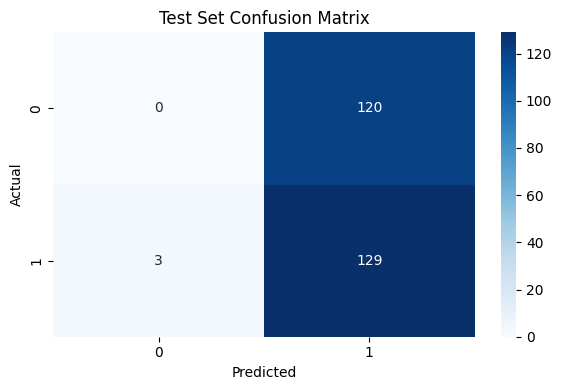

C:\Users\jainu\AppData\Local\Temp\ipykernel_17752\585074098.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='coolwarm')


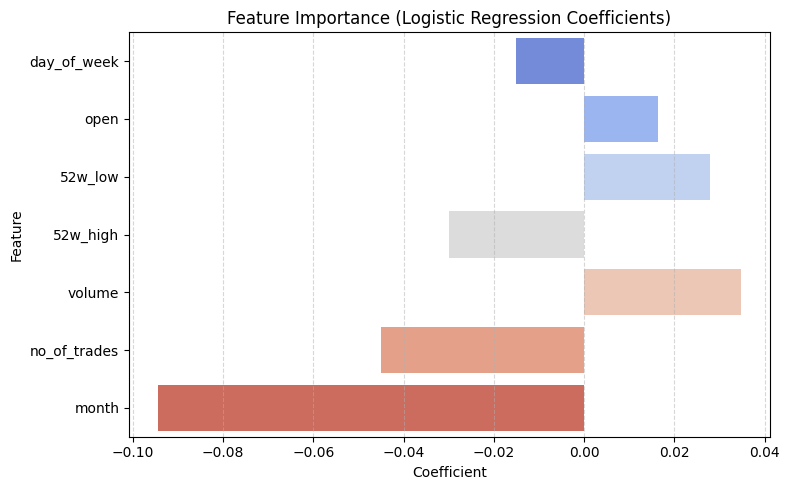

In [11]:
# Confusion Matrix Plot (Test Set)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


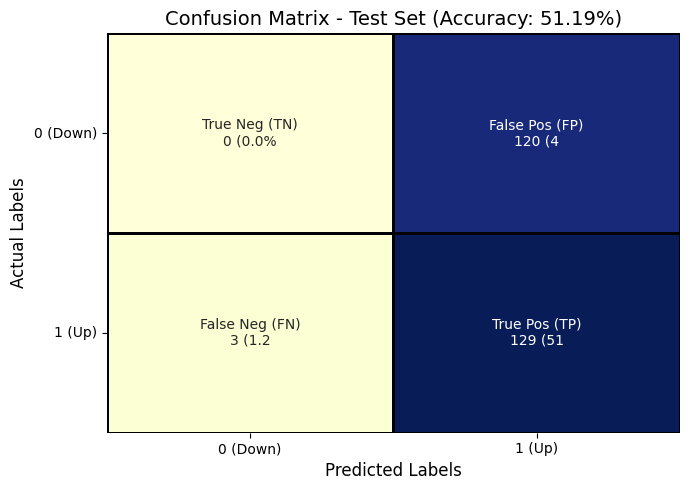

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix and percentages
cm = confusion_matrix(y_test, y_test_pred)
cm_sum = np.sum(cm)
cm_labels = np.array([["True Neg (TN)", "False Pos (FP)"],
                      ["False Neg (FN)", "True Pos (TP)"]])

# Annotate with counts and percentages
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        perc = count / cm_sum * 100
        label_text = f"{cm_labels[i, j]}\n{count} ({perc:.1f}%)"
        annot[i, j] = label_text

# Plot
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=annot, fmt='', cmap='YlGnBu', cbar=False, linewidths=1, linecolor='black')
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("Actual Labels", fontsize=12)
plt.title(f"Confusion Matrix - Test Set (Accuracy: {accuracy_score(y_test, y_test_pred):.2%})", fontsize=14)
plt.xticks([0.5, 1.5], ['0 (Down)', '1 (Up)'], rotation=0)
plt.yticks([0.5, 1.5], ['0 (Down)', '1 (Up)'], rotation=0)
plt.tight_layout()
plt.show()


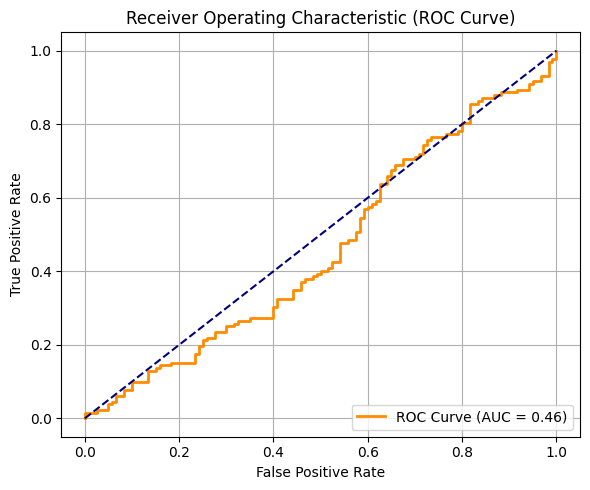

In [14]:
# ROC Curve (Test Set)
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Multinomial Logistic Regression**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [21]:
# Load the synthetic dataset
df = pd.read_csv("synthetic_stock_sector_dataset.csv")

# Encode the categorical target variable
le = LabelEncoder()
df['sector_encoded'] = le.fit_transform(df['sector'])

print(df.columns)


Index(['pe_ratio', 'debt_to_equity', 'current_ratio', 'roe',
       'net_profit_margin', 'market_cap', 'beta', 'dividend_yield',
       'volatility_30d', 'sector', 'sector_encoded'],
      dtype='object')


In [22]:
# Define features and target
features = ['pe_ratio', 'debt_to_equity', 'current_ratio', 'roe',
            'net_profit_margin', 'market_cap', 'beta', 'dividend_yield', 'volatility_30d']
X = df[features]
y = df['sector_encoded']

In [24]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [26]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)


c:\Users\jainu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [28]:
# Predict and evaluate
y_pred = model.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


🎯 Accuracy: 0.9888888888888889

📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.97      1.00      0.98        60
           2       1.00      1.00      1.00        60

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180


📊 Confusion Matrix:
 [[58  2  0]
 [ 0 60  0]
 [ 0  0 60]]


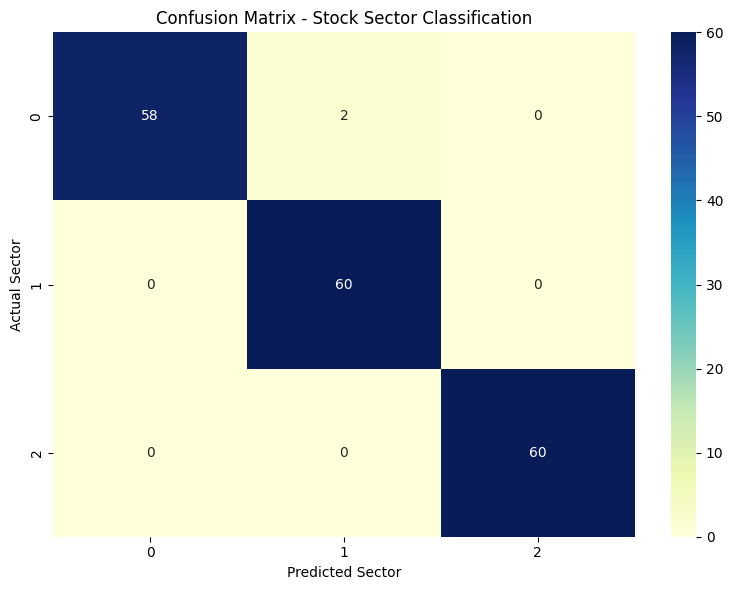

In [29]:
# Heatmap of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGnBu', fmt='d')
plt.title("Confusion Matrix - Stock Sector Classification")
plt.xlabel("Predicted Sector")
plt.ylabel("Actual Sector")
plt.tight_layout()
plt.show()

C:\Users\jainu\AppData\Local\Temp\ipykernel_17752\238233970.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
C:\Users\jainu\AppData\Local\Temp\ipykernel_17752\238233970.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jainu\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


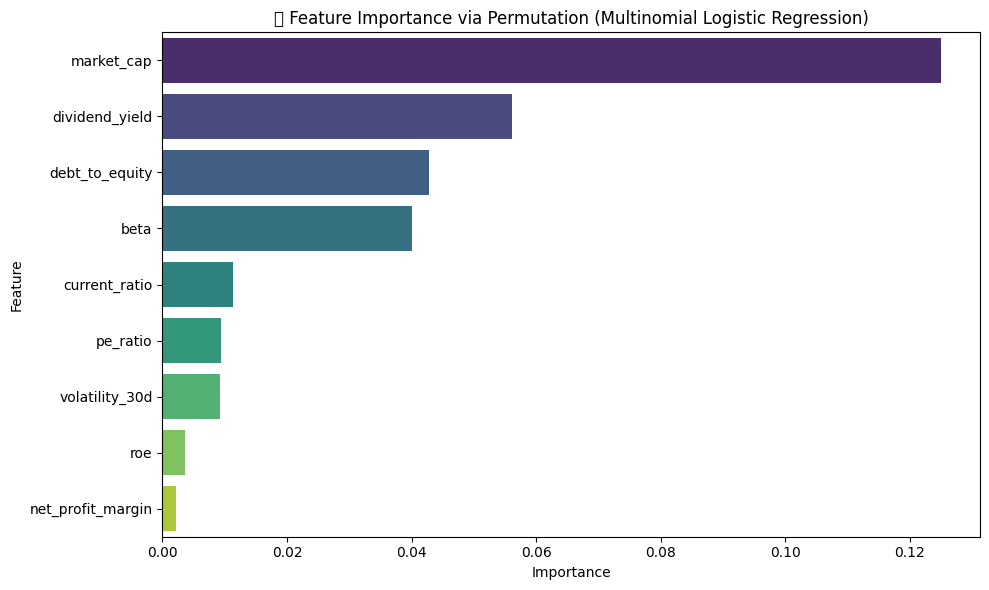

In [32]:
from sklearn.inspection import permutation_importance

# Feature importance using permutation
perm = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42, scoring='accuracy')
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("📊 Feature Importance via Permutation (Multinomial Logistic Regression)")
plt.tight_layout()
plt.show()
